# BTC-USD @24h

In [1]:
# PARAMS:
BC24H_FILENAME = './data_clean/btc_usd_24h_bitstamp.csv'
OUT_FILENAME = './results/btc24h_c.csv'
OUT_RETRAINED_FILENAME = './results/btc24h_c.ret.csv'
# TL;DR change params & Kernel > Restart & Run All to "run this like a script"

In [2]:
# autoreload
%load_ext autoreload
%autoreload 1
# write code that works in both Python 2 (2.7+) and 3 (3.5+)
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    input = raw_input
    range = xrange
except NameError:
    pass

In [3]:
import csv
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential

import pprint
pp = pprint.PrettyPrinter(indent=2).pprint
from IPython.display import display as dd
from IPython.display import Image

%matplotlib inline

Using TensorFlow backend.


In [4]:
%aimport lib.helpers
%aimport lib.etl
%aimport lib.visualization
%aimport lib.walk_forward_predict
%aimport models.rnn
%aimport models.lr
from lib.helpers import (
    timing, print_shapes, fix_all_rngs,
    date_str_to_ts
)
from lib.visualization import simple_plot
from lib.walk_forward_predict import (
    run_walk_forward_validation_rnn,
    run_walk_forward_validation_arima,
    run_walk_forward_validation_rnn_retraining
)
import lib.etl as etl
from models.rnn import make_rnn_model_constructor
from models.lr import LRModel

> size: 1351


close      float64
open       float64
high       float64
low        float64
volume     float64
missing      int64
dtype: object

,close,open,high,low,volume,missing
datetime,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0
2015-02-02,238.0,214.8,242.0,214.8,6.42,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0
2015-02-04,227.0,227.4,231.0,220.0,14.31,0
2015-02-05,217.0,227.0,228.9,213.6,4.31,0


,close,open,high,low,volume,missing
datetime,,,,,,
2018-10-09,6588.8,6604.8,6623.1,6553.1,2.25,0
2018-10-10,6517.5,6588.7,6589.8,6400.0,5.18,0
2018-10-11,6161.0,6517.5,6518.4,6067.0,9.62,0
2018-10-12,6184.9,6152.8,6238.3,6109.8,3.25,0
2018-10-13,6195.0,6180.8,6214.1,6168.8,2.27,0


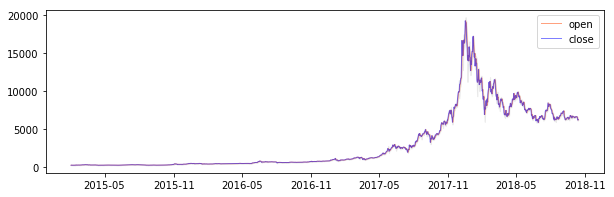

In [6]:
data24h = pd.read_csv(
    BC24H_FILENAME,
    index_col='datetime',
    parse_dates=['datetime']
)
print('> size:', len(data24h))
dd(data24h.dtypes)
dd(data24h.head())
dd(data24h.tail())
simple_plot(data24h, show_xlabels=False)

In [7]:
data24h['weekday'] = data24h.index.dayofweek
data24h.head()

,close,open,high,low,volume,missing,weekday
datetime,,,,,,,
2015-02-01,214.8,218.0,220.8,208.5,6.19,0,6
2015-02-02,238.0,214.8,242.0,214.8,6.42,0,0
2015-02-03,227.4,238.0,244.4,223.8,17.76,0,1
2015-02-04,227.0,227.4,231.0,220.0,14.31,0,2
2015-02-05,217.0,227.0,228.9,213.6,4.31,0,3


## Test runs

### LSTM

### `7|0.1|7|0.1`

**Conclusion:** Best results at 6 epochs. More consistency at 10 but average quality drops.

data ~ (600, 5)
--- 0.023s to model compilation time


--- Created model id: 139704318206864
Tensor("lstm_67_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_67 (LSTM)               (None, 7, 7)              364       
_________________________________________________________________
dropout_67 (Dropout)         (None, 7, 7)              0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 7)                 420       
_________________________________________________________________
dropout_68 (Dropout)         (None, 7)                 0         
_________________________________________________________________
dense_34 (Dense)             (None, 1)                 8         
Total params: 792
Trainable params: 792
Non-trainable params: 0
___________________________________________________________

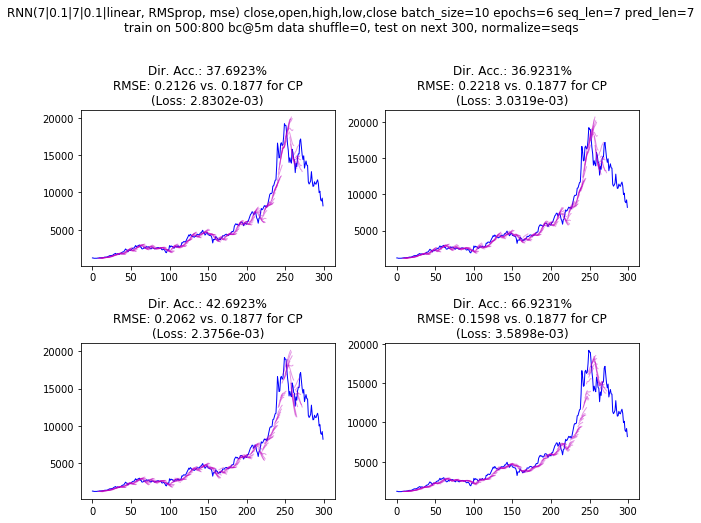

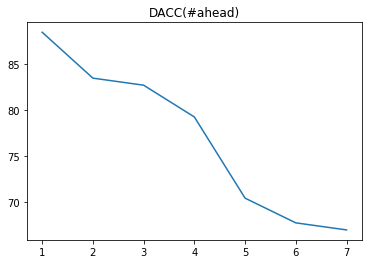

--- 60.263s to run experiment



In [17]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close'],
        from_i=500,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (1200, 5)
--- 0.025s to model compilation time


--- Created model id: 139703866087056
Tensor("lstm_199_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_199 (LSTM)              (None, 7, 7)              364       
_________________________________________________________________
dropout_199 (Dropout)        (None, 7, 7)              0         
_________________________________________________________________
lstm_200 (LSTM)              (None, 7)                 420       
_________________________________________________________________
dropout_200 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_100 (Dense)            (None, 1)                 8         
Total params: 792
Trainable params: 792
Non-trainable params: 0
_________________________________________________________

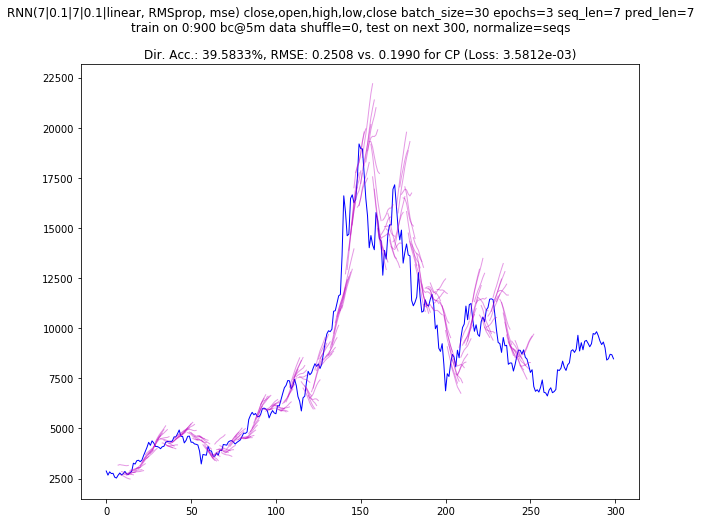

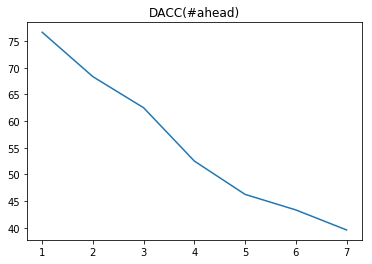

--- 30.769s to run experiment



In [39]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close'],
        from_i=0,
        train_sz=900,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([7, 0.1, 7, 0.1]),
        # training:
        epochs=3,
        batch_size=30,
        shuffle=False,
        # experiment setup:
        times=1,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 3|0.1|3|0.1

**Conclusion:** 3 epochs best.

data ~ (600, 5)
--- 0.028s to model compilation time


--- Created model id: 139704234049808
Tensor("lstm_99_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_99 (LSTM)               (None, 7, 3)              108       
_________________________________________________________________
dropout_99 (Dropout)         (None, 7, 3)              0         
_________________________________________________________________
lstm_100 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_100 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 4         
Total params: 196
Trainable params: 196
Non-trainable params: 0
___________________________________________________________

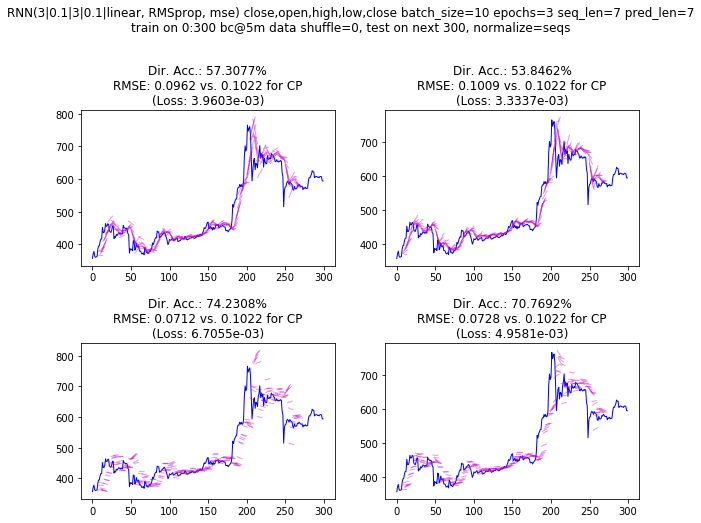

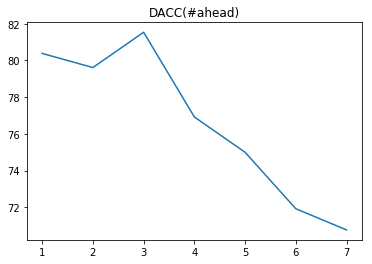

--- 72.361s to run experiment



In [21]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 14|0.1|14|0.1

**Conclusion:** Amazingly, this smaller networks gives better results than the larger ones. Best at 3 epochs.

data ~ (600, 5)
--- 0.027s to model compilation time


--- Created model id: 139703852850768
Tensor("lstm_117_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_117 (LSTM)              (None, 7, 14)             1120      
_________________________________________________________________
dropout_117 (Dropout)        (None, 7, 14)             0         
_________________________________________________________________
lstm_118 (LSTM)              (None, 14)                1624      
_________________________________________________________________
dropout_118 (Dropout)        (None, 14)                0         
_________________________________________________________________
dense_59 (Dense)             (None, 1)                 15        
Total params: 2,759
Trainable params: 2,759
Non-trainable params: 0
______________________________________________________

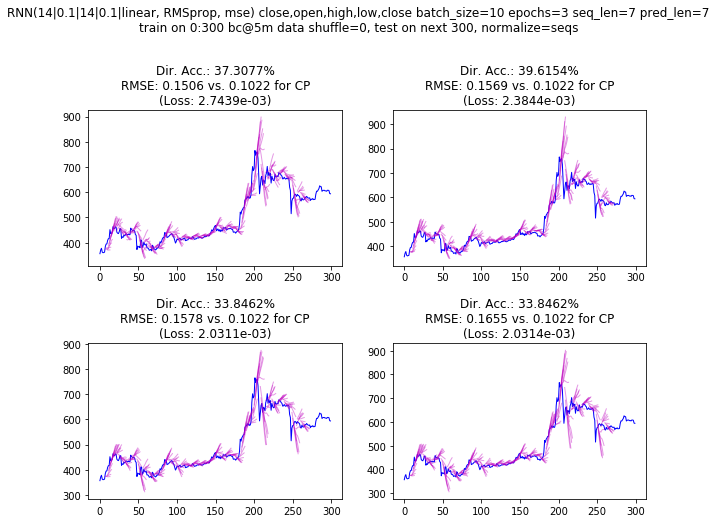

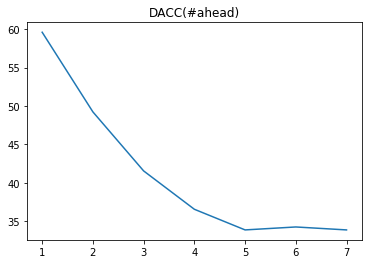

--- 84.420s to run experiment



In [24]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 5)
--- 0.028s to model compilation time


--- Created model id: 139703953588880
Tensor("lstm_125_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_125 (LSTM)              (None, 7, 14)             1120      
_________________________________________________________________
dropout_125 (Dropout)        (None, 7, 14)             0         
_________________________________________________________________
lstm_126 (LSTM)              (None, 14)                1624      
_________________________________________________________________
dropout_126 (Dropout)        (None, 14)                0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 15        
Total params: 2,759
Trainable params: 2,759
Non-trainable params: 0
______________________________________________________

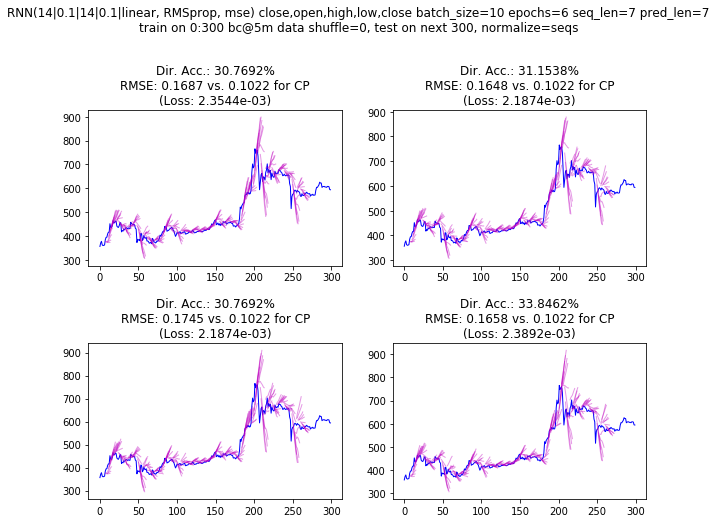

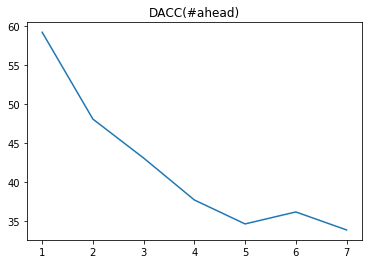

--- 93.974s to run experiment



In [25]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 5)
--- 0.023s to model compilation time


--- Created model id: 139703852921040
Tensor("lstm_133_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_133 (LSTM)              (None, 7, 14)             1120      
_________________________________________________________________
dropout_133 (Dropout)        (None, 7, 14)             0         
_________________________________________________________________
lstm_134 (LSTM)              (None, 14)                1624      
_________________________________________________________________
dropout_134 (Dropout)        (None, 14)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)                 15        
Total params: 2,759
Trainable params: 2,759
Non-trainable params: 0
______________________________________________________

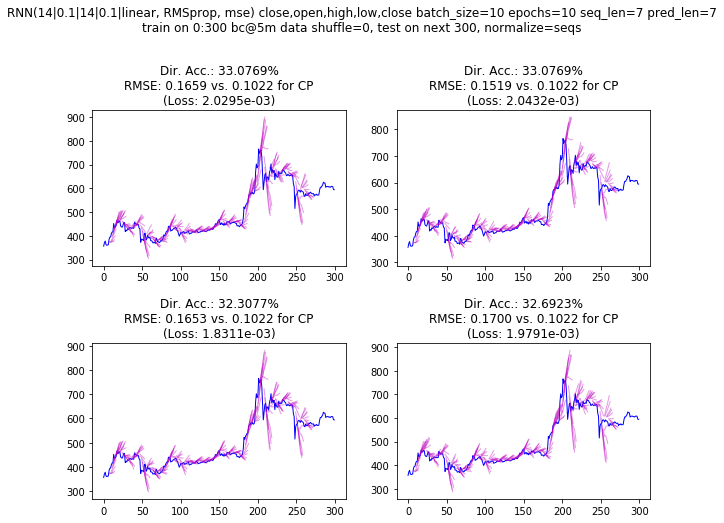

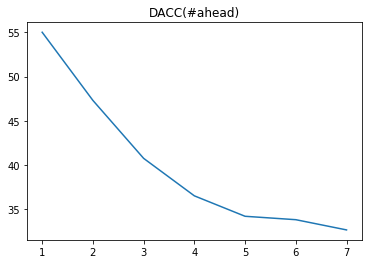

--- 99.191s to run experiment



In [26]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=10,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

data ~ (600, 5)
--- 0.023s to model compilation time


--- Created model id: 139703852848976
Tensor("lstm_141_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_141 (LSTM)              (None, 7, 14)             1120      
_________________________________________________________________
dropout_141 (Dropout)        (None, 7, 14)             0         
_________________________________________________________________
lstm_142 (LSTM)              (None, 14)                1624      
_________________________________________________________________
dropout_142 (Dropout)        (None, 14)                0         
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 15        
Total params: 2,759
Trainable params: 2,759
Non-trainable params: 0
______________________________________________________

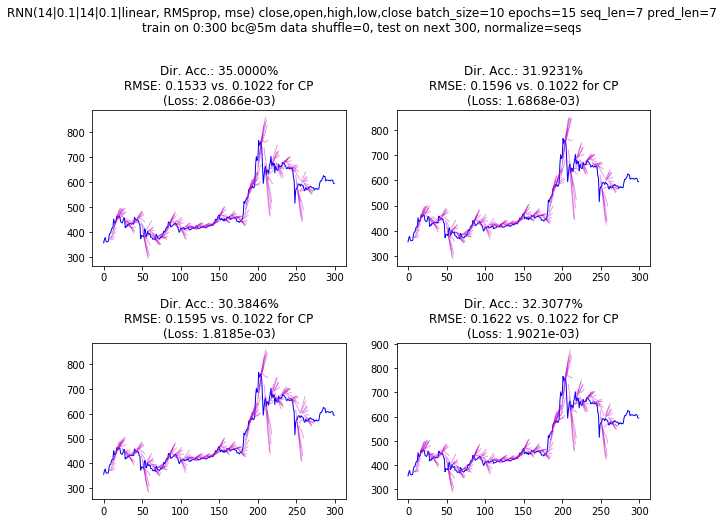

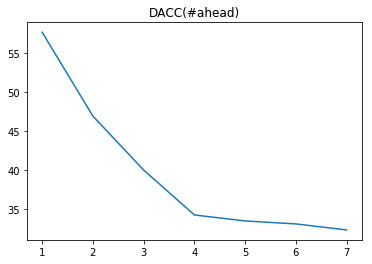

--- 119.235s to run experiment



In [27]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([14, 0.1, 14, 0.1]),
        # training:
        epochs=15,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

### 30|0.1|30|0.1

**Conclusion:** Really bad results, best at 3-6 epochs but comparatively too bad to worth condiering this further.

data ~ (900, 5)
--- 0.025s to model compilation time


--- Created model id: 139703420456592
Tensor("lstm_173_input:0", shape=(?, 7, 5), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_173 (LSTM)              (None, 7, 30)             4320      
_________________________________________________________________
dropout_173 (Dropout)        (None, 7, 30)             0         
_________________________________________________________________
lstm_174 (LSTM)              (None, 30)                7320      
_________________________________________________________________
dropout_174 (Dropout)        (None, 30)                0         
_________________________________________________________________
dense_87 (Dense)             (None, 1)                 31        
Total params: 11,671
Trainable params: 11,671
Non-trainable params: 0
____________________________________________________

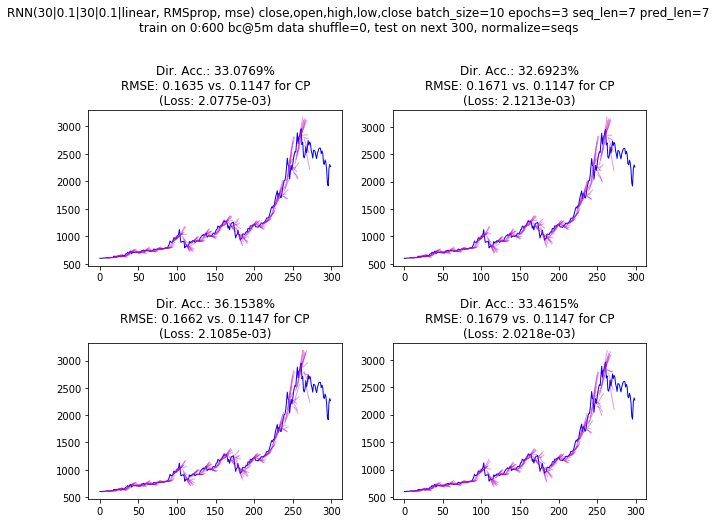

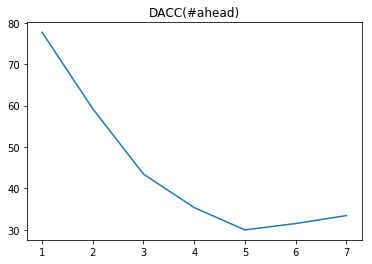

--- 122.574s to run experiment



In [31]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close', 'open', 'high', 'low', 'close'],
        from_i=0,
        train_sz=600,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([30, 0.1, 30, 0.1]),
        # training:
        epochs=3,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

## Full runs

In [46]:
len(data24h) - 600

751

In [ ]:
with timing('run experiment'):
    run_walk_forward_validation_rnn(
        # data to extract:
        data24h,
        features=['close'],
        from_i=0,
        train_sz=300,
        test_sz=300,
        # data processing:
        normalize='seqs',  # 'seqs' | 'data'
        detrend=False,
        # model and prediction arrangement:
        seq_len=7,
        pred_len=7,
        model_maker=make_rnn_model_constructor([3, 0.1, 3, 0.1]),
        # training:
        epochs=6,
        batch_size=10,
        shuffle=False,
        # experiment setup:
        times=4,
        skip=False,
        fix_all_rngs_to=False,
        fix_rngs_before_each=False,
        # plotting:
        fig_size=(10, 8),
        fast=True,
    )

In [49]:
DEFAULT_PARAMS = {
    # data to extract:
    'data_df': data24h,
    'features': ['close'],
    'train_sz': 300,
    'test_sz': 300,
    # data processing:
    'normalize': 'seqs',  # 'seqs' | 'data'
    'detrend': False,
    # model and prediction arrangement:
    'seq_len': 7,
    'pred_len': 7,
    'model_maker': make_rnn_model_constructor([3, 0.1, 3, 0.1]),
    # training:
    'epochs': 6,
    'batch_size': 10,
    'shuffle': False,
    # experiment setup:
    'times': 1,
    'skip': False,
    'fix_all_rngs_to': False,
    'fix_rngs_before_each': False,
    # plotting:
    'plot': True,
    'fig_size': (10, 8),
    'fast': True,
}

CSV_FIELDS = (
    'model_description',
    'train_from',
    'train_to',
    'test_on',
    'shuffle',
    'normalize',
    'training_loss',
    'rmse',
    'rmse_cp',
    'dir_acc',
)

In [50]:
def ddump(s):
    """Print to both notebook and system stdout."""
    os.write(1, s)
    print(s)

In [57]:
def full_run(idx_from, idx_to, write_csv_header=False):
    train_sz = DEFAULT_PARAMS['train_sz']
    test_sz = DEFAULT_PARAMS['test_sz']
    
    out_file = open(OUT_FILENAME, 'ab')
    csv_writer = csv.DictWriter(out_file, fieldnames=CSV_FIELDS)
    if write_csv_header:
        csv_writer.writeheader()
        
    with timing('full run %d - %d' % (idx_from, idx_to)):
        for i in range(idx_from, idx_to, test_sz):
            params = dict(DEFAULT_PARAMS,
                          from_i=i - train_sz)
            ddump("\n   ------ RUN %d (from %s, train on %d, test on %d)\n" % (
                i, params['from_i'], params['train_sz'], params['test_sz']))
            with timing('run segment'):
                out = run_walk_forward_validation_rnn(**params)
                csv_writer.writerow(out)
                out_file.flush()


   ------ RUN 300 (from 0, train on 300, test on 300)

data ~ (600, 1)
--- 0.026s to model compilation time


--- Created model id: 140665432782928
Tensor("lstm_205_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_205 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_205 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_206 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_206 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_103 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 148
Non-trainable params: 0
__

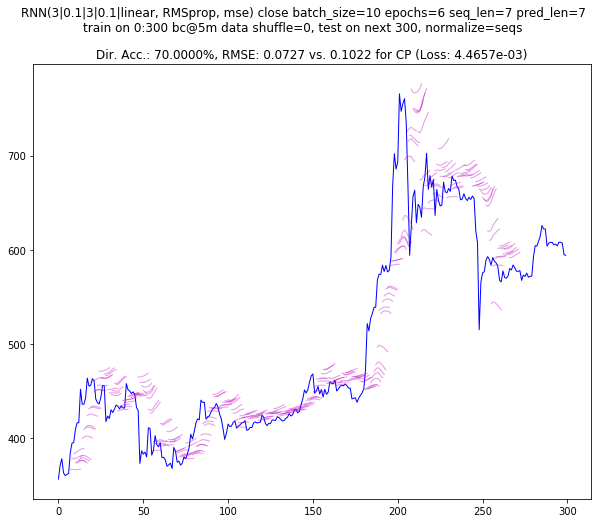

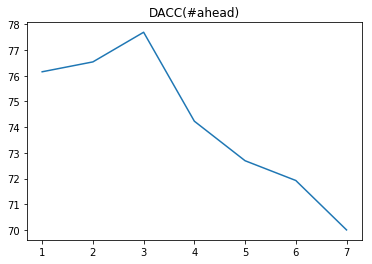

--- 32.282s to run segment


   ------ RUN 600 (from 300, train on 300, test on 300)

data ~ (600, 1)
--- 0.033s to model compilation time


--- Created model id: 140665235205392
Tensor("lstm_207_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_207 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_207 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_208 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_208 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

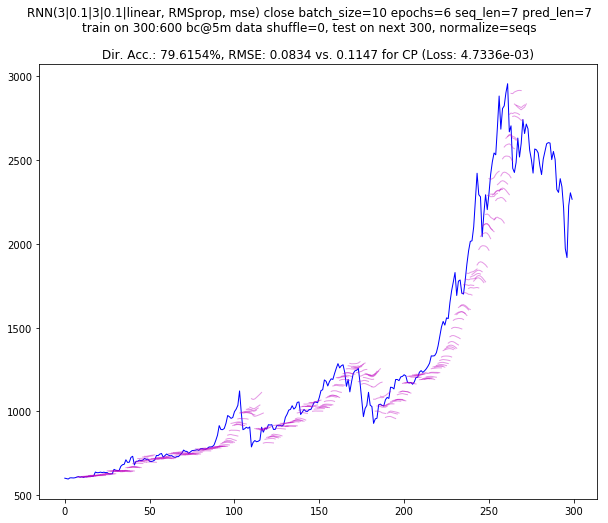

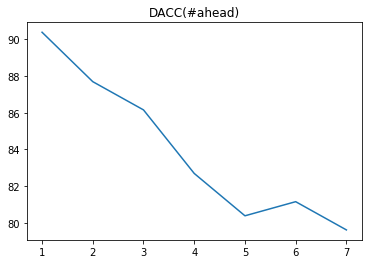

--- 32.012s to run segment


   ------ RUN 900 (from 600, train on 300, test on 300)

data ~ (600, 1)
--- 0.040s to model compilation time


--- Created model id: 140665434358224
Tensor("lstm_209_input:0", shape=(?, 7, 1), dtype=float32)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_209 (LSTM)              (None, 7, 3)              60        
_________________________________________________________________
dropout_209 (Dropout)        (None, 7, 3)              0         
_________________________________________________________________
lstm_210 (LSTM)              (None, 3)                 84        
_________________________________________________________________
dropout_210 (Dropout)        (None, 3)                 0         
_________________________________________________________________
dense_105 (Dense)            (None, 1)                 4         
Total params: 148
Trainable params: 

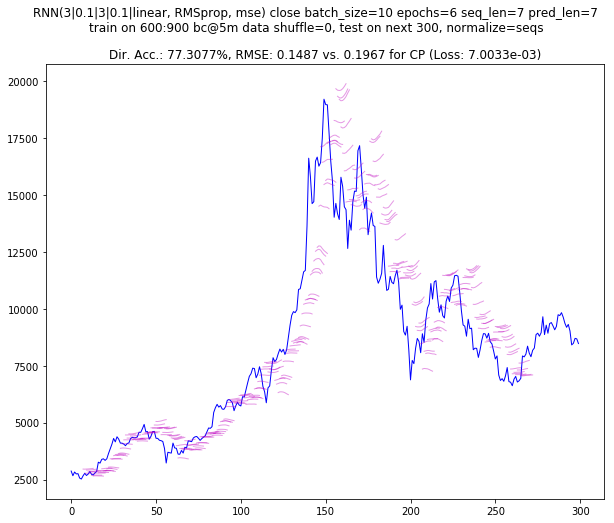

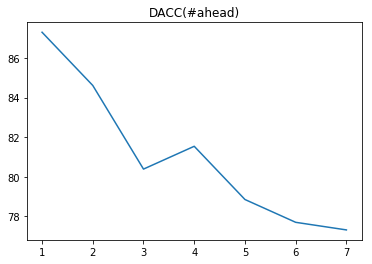

--- 35.839s to run segment

--- 100.134s to full run 300 - 1051



In [61]:
full_run(300, 1051, write_csv_header=False)

In [62]:
dd(pd.read_csv(OUT_FILENAME))

,model_description,train_from,train_to,test_on,shuffle,normalize,training_loss,rmse,rmse_cp,dir_acc
0,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",0,300,300,False,seqs,0.004466,0.0727%,0.1022%,70.0000%
1,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",300,600,300,False,seqs,0.004734,0.0834%,0.1147%,79.6154%
2,"RNN(3|0.1|3|0.1|linear, RMSprop, mse) close ba...",600,900,300,False,seqs,0.007003,0.1487%,0.1967%,77.3077%
